In [1]:
from pathlib import Path
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib as matplotlib
import matplotlib.pyplot as plt

import statsmodels.api as sm
import scipy.stats as sps

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, GroupKFold, LeaveOneGroupOut, PredefinedSplit, cross_val_predict
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet, lasso_path
from sklearn.dummy import DummyRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from xgboost import XGBRegressor

pd.options.mode.chained_assignment = None  # default='warn'
%load_ext autoreload
%autoreload 2

/Users/etriesch/dev/forest-biomass-modeling/venv/forest-biomass-modeling/lib/python3.9/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


In [2]:
from utils import DATA_PATH, DATA_CLEAN_PATH, RESULTS_PATH
from utils import set_plt_settings, GEO_CRS
from train_functions import scoring_default, run_cv

set_plt_settings()
write_mode = True

## Make analytic datasets

In [3]:
# read in
df = pd.read_csv(DATA_CLEAN_PATH / 'analysis_df.csv')

# make target and features
X = df.loc[:, [col for col in df.columns if col.startswith(('ndvi', 'lst'))]]
y = (df.total / df.area_km).to_numpy() # short tons per km^2
g_county = df.countyfp.to_numpy()
g_state = df.statefp.to_numpy()
g_report = df.report.to_numpy()

# scale features
scaler = StandardScaler(copy=True, with_mean=True, with_std=True)
scaler.fit(X)
X_scaled = pd.DataFrame(scaler.transform(X), columns=X.columns)

## Generate hold-out test data and splitters

In [4]:
# county kfold
idx_train, idx_test = train_test_split(range(len(y)), test_size=0.10, random_state=1, shuffle=True, stratify=None)

df_county_train, df_county_test = df.loc[idx_train], df.loc[idx_test]
X_county_train, X_county_test = X.loc[idx_train], X.loc[idx_test]
y_county_train, y_county_test = y[idx_train], y[idx_test]
g_county_train = g_county[idx_train]
print('county test set percent:', len(y_county_test) / len(y))

# state LOO
np.random.seed(123456)
test_states = np.unique(np.random.choice(df.state, 5))
idx_train, idx_test = df.loc[~df.state.isin(test_states)].index, df.loc[df.state.isin(test_states)].index

df_state_train, df_state_test = df.loc[idx_train], df.loc[idx_test]
X_state_train, X_state_test = X.loc[idx_train], X.loc[idx_test]
y_state_train, y_state_test = y[idx_train], y[idx_test]
g_state_train = g_state[idx_train]
print('test states:', test_states)
print('state test set percent:', len(y_state_test) / len(y))

# last report
idx_train, idx_test = df.loc[~df.last_report].index, df.loc[df.last_report].index

df_report_train, df_report_test = df.loc[idx_train], df.loc[idx_test]
X_report_train, X_report_test = X.loc[idx_train], X.loc[idx_test]
y_report_train, y_report_test = y[idx_train], y[idx_test]
g_report_train = g_report[idx_train]
print('report test set percent:', len(y_report_test) / len(y))

county test set percent: 0.1
test states: ['Alabama' 'Minnesota' 'Ohio' 'Wisconsin']
state test set percent: 0.12928571428571428
report test set percent: 0.32071428571428573


In [5]:
# define splitters
splitter_countyKFold = GroupKFold(5)
splitter_stateLOO = LeaveOneGroupOut()
splitter_lastReport = LeaveOneGroupOut()
scoring_report = scoring_default.copy()
scoring_report.pop('r_squared')

'r2'

In [48]:
# set parameters for training and evaluation
split_name = 'lastReport'

if split_name == 'countyKFold':
    splitter, groups, scoring = splitter_countyKFold, g_county_train, scoring_default
    df_train, df_test = df_county_train, df_county_test
    X_train, X_test = X_county_train, X_county_test
    y_train, y_test = y_county_train, y_county_test
    params_enet={'alpha':[1000], 'l1_ratio':[0.9]} # county
    params_dt={'min_samples_leaf': [10], 'max_depth': [10]} # county
    params_rf={'min_samples_leaf': [2], 'max_depth': [None]} # county
    params_xgb={'reg_alpha':[0.1], 'reg_lambda':[90], 'tree_method':['hist']} # county
    params_fcnet={'hidden_layer_sizes': [(4000, 1000)]} # county
    
elif split_name == 'stateLOO':
    splitter, groups, scoring = splitter_stateLOO, g_state_train, scoring_default
    df_train, df_test = df_state_train, df_state_test
    X_train, X_test = X_state_train, X_state_test
    y_train, y_test = y_state_train, y_state_test
    params_enet={'alpha':[3600], 'l1_ratio':[0.95]} # state
    params_dt={'min_samples_leaf': [8], 'max_depth': [10]} # state
    params_rf={'min_samples_leaf': [2], 'max_depth': [50]} # state
    params_xgb={'reg_alpha':[10], 'reg_lambda':[10], 'tree_method':['approx']} # state
    params_fcnet={'hidden_layer_sizes': [(1000)]} # state
    
elif split_name == 'lastReport':
    splitter, groups, scoring = splitter_lastReport, g_report_train, scoring_default
    df_train, df_test = df_report_train, df_report_test
    X_train, X_test = X_report_train, X_report_test
    y_train, y_test = y_report_train, y_report_test
    params_enet={'alpha':[1000], 'l1_ratio':[0.9]} # report
    params_dt={'min_samples_leaf': [10], 'max_depth': [9]} # report
    params_rf={'min_samples_leaf': [1], 'max_depth': [None]} # report
    params_xgb={'reg_alpha':[1], 'reg_lambda':[1], 'tree_method':['approx']} # report
    params_fcnet={'hidden_layer_sizes': [(4000)]} # report
    
print(f'set settings for {split_name} with {splitter} and {scoring}')

set settings for lastReport with LeaveOneGroupOut() and {'neg_root_mean_squared_error': 'neg_root_mean_squared_error', 'neg_mean_absolute_error': 'neg_mean_absolute_error', 'r_squared': 'r2'}


## Cross validate contending models

In [82]:
# dummy regressor
params={}
cv_mean = run_cv(X=X_train, y=y_train, estimator=DummyRegressor(), params=params, scoring=scoring, cv=splitter, groups=groups)
cv_mean['min']

Fitting 44 folds for each of 1 candidates, totalling 44 fits


model     DummyRegressor()
params                  {}
rmse           4630.308813
mae            4040.330396
r_sq            -29.384309
Name: 0, dtype: object

In [83]:
# linear regression
params={}
cv_lm = run_cv(X=X_train, y=y_train, estimator=LinearRegression(), params=params, scoring=scoring, cv=splitter, groups=groups)
cv_lm['min']

Fitting 44 folds for each of 1 candidates, totalling 44 fits


model     LinearRegression()
params                    {}
rmse             2255.098443
mae              1768.548251
r_sq               -2.367332
Name: 0, dtype: object

In [84]:
# Elastic Net
# params={'alpha':[j*(10**i) for i in range(3, 5) for j in range(1, 9)], 'l1_ratio':[0.1, 0.25, 0.5, 0.9]}
cv_enet = run_cv(X=X_train, y=y_train, estimator=ElasticNet(), params=params_enet, scoring=scoring, cv=splitter, groups=groups)
cv_enet['min']

Fitting 44 folds for each of 1 candidates, totalling 44 fits


model                          ElasticNet()
params    {'alpha': 3600, 'l1_ratio': 0.95}
rmse                             2444.80062
mae                             1933.843879
r_sq                              -6.697469
Name: 0, dtype: object

In [85]:
# decision tree regression
# params={'min_samples_leaf': [8, 10, 12], 'max_depth': [10, 20, 30]} # 10 10
cv_dt = run_cv(X=X_train, y=y_train, estimator=DecisionTreeRegressor(), params=params_dt, scoring=scoring, cv=splitter, groups=groups)
cv_dt['min']

Fitting 44 folds for each of 1 candidates, totalling 44 fits


model                      DecisionTreeRegressor()
params    {'max_depth': 10, 'min_samples_leaf': 8}
rmse                                   1999.748013
mae                                    1485.874296
r_sq                                     -0.934683
Name: 0, dtype: object

In [86]:
# xgboost regression
# params={'reg_alpha':[.01, .1, 1, 10, 100], 'reg_lambda':[0.1, .1, 1, 10, 100], 'tree_method':['approx', 'hist']} # .1, 100 hist
cv_xgb = run_cv(X=X_train, y=y_train, estimator=XGBRegressor(objective="reg:squarederror"), params=params_xgb, scoring=scoring, cv=splitter, groups=groups)
cv_xgb['min']

Fitting 44 folds for each of 1 candidates, totalling 44 fits


model     XGBRegressor(base_score=None, booster=None, ca...
params    {'reg_alpha': 10, 'reg_lambda': 10, 'tree_meth...
rmse                                            1691.552988
mae                                             1284.281212
r_sq                                              -0.711811
Name: 0, dtype: object

In [87]:
# random forest regression
# params={'min_samples_leaf': [2, 5, 8], 'max_depth': [None, 100, 50]} # 
cv_rf = run_cv(X=X_train, y=y_train, estimator=RandomForestRegressor(), params=params_rf, scoring=scoring, cv=splitter, groups=groups)
cv_rf['min']

Fitting 44 folds for each of 1 candidates, totalling 44 fits


model                      RandomForestRegressor()
params    {'max_depth': 50, 'min_samples_leaf': 2}
rmse                                   1621.441232
mae                                    1227.167631
r_sq                                     -0.739369
Name: 0, dtype: object

In [14]:
# N-layer fully connected neural net
cv_fcnet = run_cv(X=X_train, y=y_train, estimator=MLPRegressor(), params=params_fcnet, scoring=scoring, cv=splitter, groups=groups)
cv_fcnet['min']

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Users/etriesch/dev/forest-biomass-modeling/venv/forest-biomass-modeling/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:709: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")

KeyboardInterrupt



## Summarize and save

In [88]:
# All results (for the records)
# setup
key='all'
filename = f'cv_{key}_{split_name}.csv'
filepath = RESULTS_PATH / filename
filepath.parent.mkdir(parents=True, exist_ok=True)
# make and save
cv_all = pd.concat((cv_mean[key], cv_lm[key], cv_enet[key], cv_dt[key], cv_rf[key], cv_xgb[key] 
#                     ,cv_fcnet[key]
                  ))
if write_mode:
    cv_all.to_csv(filepath, index=False)

# min results
# setup
key='min'
filename = f'cv_{key}_{split_name}.csv'
filepath = RESULTS_PATH / filename
filepath.parent.mkdir(parents=True, exist_ok=True)
# make and save
cv_min = pd.DataFrame((cv_mean[key], cv_lm[key], cv_enet[key], cv_dt[key], cv_rf[key], cv_xgb[key] 
#                        ,cv_fcnet[key]
                     ))
if write_mode:
    cv_min.to_csv(filepath, index=False)

In [89]:
cv_min

,model,params,rmse,mae,r_sq
0,DummyRegressor(),{},4630.308813,4040.330396,-29.384309
0,LinearRegression(),{},2255.098443,1768.548251,-2.367332
0,ElasticNet(),"{'alpha': 3600, 'l1_ratio': 0.95}",2444.800620,1933.843879,-6.697469
0,DecisionTreeRegressor(),"{'max_depth': 10, 'min_samples_leaf': 8}",1999.748013,1485.874296,-0.934683
0,RandomForestRegressor(),"{'max_depth': 50, 'min_samples_leaf': 2}",1621.441232,1227.167631,-0.739369
0,"XGBRegressor(base_score=None, booster=None, ca...","{'reg_alpha': 10, 'reg_lambda': 10, 'tree_meth...",1691.552988,1284.281212,-0.711811


# Final summary table

In [11]:
# read in all results and summarize
results_min = pd.DataFrame()
for name in ['countyKFold', 'stateLOO', 'lastReport']:
    m = pd.read_csv(RESULTS_PATH / f'cv_min_{name}.csv')
    m.loc[:, 'split'] = name
    order_cols = ['split', 'model', 'params']
    new_col_order = order_cols + m.columns.drop(order_cols).tolist()
    m = m[new_col_order]
    results_min = pd.concat((m, results_min))
    
print(results_min.round(2).drop(columns=['params']).to_latex())

\begin{tabular}{lllrrr}
\toprule
{} &        split &                                              model &     rmse &      mae &   r\_sq \\
\midrule
0 &   lastReport &                                   DummyRegressor() &  3880.42 &  3234.15 &  -0.19 \\
1 &   lastReport &                                 LinearRegression() &  1874.07 &  1397.22 &   0.73 \\
2 &   lastReport &                                       ElasticNet() &  2006.74 &  1513.82 &   0.69 \\
3 &   lastReport &                            DecisionTreeRegressor() &  1773.12 &  1113.92 &   0.77 \\
4 &   lastReport &                            RandomForestRegressor() &  1474.71 &   900.80 &   0.84 \\
5 &   lastReport &  XGBRegressor(base\_score=None, booster=None, ca... &  1466.28 &   925.23 &   0.84 \\
0 &     stateLOO &                                   DummyRegressor() &  4630.31 &  4040.33 & -29.38 \\
1 &     stateLOO &                                 LinearRegression() &  2255.10 &  1768.55 &  -2.37 \\
2 &     stateLOO & 

/var/folders/mw/dy3m3wg11js6x91fwng5ptdw0000gn/T/ipykernel_66861/1697012709.py:11: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(results_min.round(2).drop(columns=['params']).to_latex())


# Analyze performance on test set

In [49]:
# make predictions on test set
# final_params = params_xgb
# final_model = XGBRegressor(objective="reg:squarederror")
final_params = params_rf
final_model = RandomForestRegressor()
final_params = {k:i[0] for k, i in final_params.items()}
final_model.set_params(**final_params)

final_model.fit(X_train, y_train)
y_test_pred = final_model.predict(X_test)

# calculate error
error = y_test_pred - y_test
error_rel = error / y_test * 100

## True vs. predicted

In [50]:
# calculate metrics
final_scores = {}
final_scores['RMSE'] = np.sqrt(mean_squared_error(y_test, y_test_pred))
final_scores['MAE'] = mean_absolute_error(y_test, y_test_pred)
final_scores['R^2'] = r2_score(y_test, y_test_pred)
print(final_scores)

{'RMSE': 1610.3230785091198, 'MAE': 1075.642240486396, 'R^2': 0.8877771108605523}


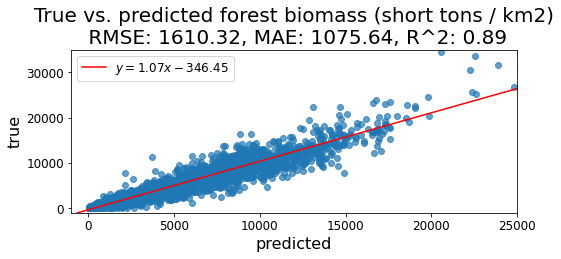

In [51]:
# plot predictions against actuals
fig, ax = plt.subplots(figsize=(8, 3))
plt.scatter(x=y_test_pred, y=y_test, alpha=0.7)

# compute slope m and intercept b
m, b = np.polyfit(y_test_pred, y_test, deg=1)
# plot fitted y = m*x + b
plt.axline(xy1=(0, b), slope=m, color='r', label=f'$y = {m:.2f}x {b:+.2f}$')

plt.legend()
plt.xlabel('predicted')
plt.ylabel('true')
ax.set_xlim((-1000, 25000))
ax.set_ylim((-1000, 35000))
plt.savefig(RESULTS_PATH / 'fig_regfuture.png', bbox_inches='tight')
newline = ','
plt.title(f'True vs. predicted forest biomass (short tons / km2)\n {", ".join(f"{k}: {final_scores[k]:0.2f}" for k in final_scores.keys())}')
plt.show()

## Visualize errors

In [52]:
# create columns and merge onto county data
drop_pctl = 10
error_rel_trim = error_rel
error_rel_trim[(error_rel < np.percentile(error_rel, drop_pctl)) | (error_rel > np.percentile(error_rel, 100 - drop_pctl))] = np.nan

fips_test = df_test.loc[:,['fips']]
fips_test.loc[:, 'y_pred_error'] = error
fips_test.loc[:, 'y_pred_error_rel'] = error_rel_trim

c_filepath = str(DATA_PATH / 'county_shapefiles/cb_2018_us_county_5m.shp')
counties = gpd.read_file(c_filepath).to_crs(GEO_CRS)
counties.columns = counties.columns.str.lower()
counties.loc[:, 'fips'] = (counties.statefp + counties.countyfp).astype(int)
# drop non-contiguous us regions
counties = counties.loc[~counties.statefp.isin(['02', '15', '60', '66', '72', '69', '78'])]

# merge on FS data
county_fs = counties.merge(right=fips_test, how='right', on='fips')

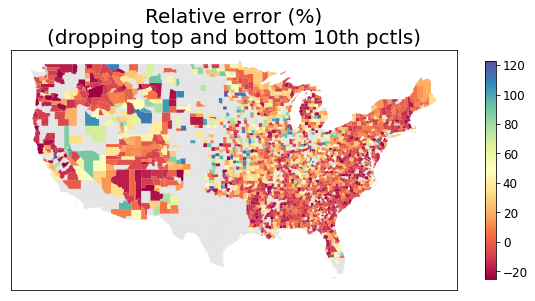

In [53]:
# plot
title = f'Relative error (%)\n(dropping top and bottom {drop_pctl}th pctls)'
gdf = county_fs
value_col = 'y_pred_error_rel'

fig, ax = plt.subplots(figsize=(10, 5))
counties.plot(ax=ax, color='grey', alpha=0.2)
gdf.plot(ax=ax, column=value_col, legend=True, legend_kwds={'shrink': 0.8}, cmap='Spectral') # https://matplotlib.org/2.0.2/users/colormaps.html
ax.get_yaxis().set_visible(False)
ax.get_xaxis().set_visible(False)
plt.title(title)
plt.show()

## Overall sample test

In [54]:
stats = {}
# Country-level prediction
true_cbiomass = y_test.mean()
true_cbiomass_var = y_test.var()
pred_cbiomass = y_test_pred.mean()
pred_cbiomass_var = y_test_pred.var()

stat, pvalue = sps.levene(y_test, y_test_pred)
stats['Levene equal variance'] = np.round(pvalue, 4)

# Paired t-test
stat, pvalue = sps.ttest_rel(y_test, y_test_pred)
stats['Paired t-test'] = np.round(pvalue, 4)

# Signed rank test
stat, pvalue = sps.wilcoxon(y_test, y_test_pred)
stats['Signed rank test'] = np.round(pvalue, 4)

print(stats)

{'Levene equal variance': 0.0, 'Paired t-test': 0.1334, 'Signed rank test': 0.0581}


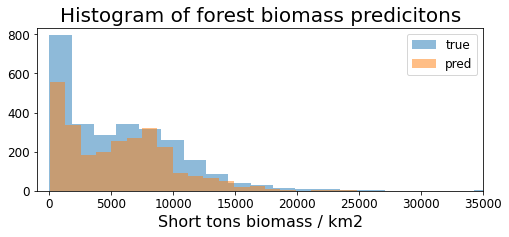

In [55]:
fig, ax = plt.subplots(figsize=(8,3))

plt.hist(y_test, alpha=0.5, bins=20, label='true')
plt.hist(y_test_pred, alpha=0.5, bins=20, label='pred')
plt.xlabel('Short tons biomass / km2')
ax.set_xlim((-1000, 35000))
plt.legend()

plt.savefig(RESULTS_PATH / 'fig_histfuture.png', bbox_inches='tight')

plt.title('Histogram of forest biomass predicitons')
plt.show()